In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyval as polynomial
import scipy.stats
%matplotlib inline

## Utility functions

### Data generation

In [2]:
def generate_data_pts(f, theta, x_pts=None, x_start=-5.0, x_stop=5.0, n_pts=10, y_sigma=0.2):
    if x_pts is None:
        x_pts = scipy.stats.uniform.rvs(loc=x_start, scale=(x_stop-x_start), size=n_pts)
    y_mean = f(x_pts, theta)
    y_pts = scipy.stats.norm.rvs(loc=y_mean, scale=y_sigma)
    return x_pts, y_pts

## Our model

Create design matrix with polynomial feautues

In [3]:
def create_polynomial_design_matrix_from_x_pts(x_pts, npol):
    nsamples = len(x_pts)
    nfeatures = npol+1
    xvec = np.array(x_pts)
    X = np.zeros((nsamples, nfeatures))
    X[:,0] = 1
    X[:,1] = xvec.T
    for col in range(2,nfeatures):
        X[:,col] = xvec**col 
    return X

Calculate the optimal $\theta$ using the normal equation

In [4]:
def calc_optimal_theta_via_normal_equation(X, y, lam):
    nsamples, nfeatures = np.shape(X)
    L = np.identity(nfeatures)*lam
    L[0,0] = 0
    theta = np.dot(np.dot( np.linalg.inv(np.dot(X.T,X) + L), X.T), y)
    return theta

Calculate the value of the cost function

In [5]:
def calc_cost_model(y_obs, y_pred, lam, theta):
    D = y_obs - y_pred
    cost = np.dot(D.T,D) + lam*np.dot(theta.T,theta)
    return cost

In [6]:
def calc_cost_noise(f_truth, x_pts, y_obs_pts):
    y_truth_mean_pts = np.array(f_truth(x_pts))
    D = y_obs_pts - y_truth_mean_pts
    cost_noise = np.dot(D.T,D)
    return cost_noise

In [7]:
def calc_cost_bias(f_truth, x_pts, y_pred_mean):
    y_truth_mean_pts = np.array(f_truth(x_pts))
    D = y_pred_mean - y_truth_mean_pts
    cost_bias = np.dot(D.T, D)
    return cost_bias

Best fit model y predictions

In [8]:
def calc_y_pred(X, theta_opt):
    y_pred = np.dot(X,theta_opt)
    return y_pred

Generate an ensemble of experiment with a fixed set of hyperparameters

In [36]:
def generate_experiment_ensemble(f_truth, theta_truth,
                                 model_pol_degree,
                                 lam=0.0,
                                 y_sigma=0.1,
                                 x_start=-5.0, x_stop=5.0, x_pts=None,
                                 n_pts=10, n_trials=100):
    
    ### --- Truth y mean curve
    x_truth_mean_grid = np.linspace(x_start, x_stop, 100)
    y_truth_mean_grid = f_truth(x_truth_mean_grid, theta_truth)
    
    ### --- Generate observed dataset
    data_ensemble = [generate_data_pts(f_truth, theta_truth, x_start=x_start, x_stop=x_stop, x_pts=x_pts, n_pts=n_pts, y_sigma=y_sigma) for i in range(n_trials)]
    data_ensemble = np.array(data_ensemble)
    
    # - Construct design matrices
    X_ensemble = [create_polynomial_design_matrix_from_x_pts(x_pts, model_pol_degree) for x_pts, y_pts  in data_ensemble]
    X_ensemble = np.array(X_ensemble)
    
    ### --- Infer best fit model for each dataset
    
    ## - Determine theta_opts
    theta_opt_ensemble = [calc_optimal_theta_via_normal_equation(X, y_obs, lam) for X, (x_obs, y_obs) in zip(X_ensemble, data_ensemble)]
    theta_opt_ensemble = np.array(theta_opt_ensemble)
    
    ## - Calculate y_preds
    y_pred_ensemble = [calc_y_pred(X, theta_opt) for X, theta_opt in zip(X_ensemble, theta_opt_ensemble)]
    y_pred_ensemble = np.array(y_pred_ensemble)
    
    ## - Calculate y_truth_mean
    # - UNFINISHED (START HERE)
    #y_truth_mean_ensemble = [f_truth()]
    
    ## - Calculate costs
    
    # - Total cost
    cost_ensemble_total = [calc_cost_model(y_obs, y_pred, lam, theta_opt) for (x_obs, y_obs), y_pred, theta_opt in zip(data_ensemble, y_pred_ensemble, theta_opt_ensemble)]
    cost_ensemble_total = np.array(cost_ensemble_total)
    
    # - Cost from noise
    # - UNFINISHED
    #cost_ensemble_noise = [calc_cost_noise(f_truth)]
    
    ### --- Store results
    experiment_ensemble = {}
    experiment_ensemble['n_pts'] = n_pts
    experiment_ensemble['n_trials'] = n_trials
    experiment_ensemble['model_pol_degree'] = model_pol_degree
    experiment_ensemble['data'] = data_ensemble
    experiment_ensemble['X'] = X_ensemble
    experiment_ensemble['theta_opt'] = theta_opt_ensemble
    experiment_ensemble['y_pred'] = y_pred_ensemble
    experiment_ensemble['cost_total'] = cost_ensemble_total
    experiment_ensemble['truth_mean'] = (x_truth_mean_grid, y_truth_mean_grid)
    
    return experiment_ensemble

In [37]:
def mean_machine(x_obs_pts, y_obs_pts, x_min, x_max, x_nbins):
    x_bin_edges = np.linspace(x_min, x_max, x_nbins+1, endpoint=True)
    inds = np.digitize(x_obs_pts, x_bin_edges)
    y_mean = np.zeros((x_nbins,))
    counter = np.zeros((x_nbins,))
    #y_histo = np.histogram(y_obs_pts, x_bins)
                      
    for idx, y_obs_pt in zip(inds, y_obs_pts):
        y_mean[idx-1] += y_obs_pt
        counter[idx-1] += 1
    y_mean = np.divide(y_mean,counter)
    return y_mean

### Plotting functions

In [38]:
def plot_data_pts_from_experiment_ensemble(experiment_ensemble, alpha=0.2):
    
    x_pts_ensemble, y_pts_ensemble = experiment_ensemble['data'][:,0], experiment_ensemble['data'][:,1]
    
    f,a = plt.subplots()
    for x_pts, y_pts in zip(x_pts_ensemble, y_pts_ensemble):
        a.scatter(x_pts, y_pts, c='b', alpha=alpha)
    return f,a

In [39]:
def plot_pred_pts_from_experiment_ensemble(experiment_ensemble, alpha=0.2):
    
    x_pts_ensemble, y_pred_ensemble = experiment_ensemble['data'][:,0], experiment_ensemble['y_pred']
    
    f,a = plt.subplots()
    for x_pred, y_pred in zip(x_pts_ensemble, y_pred_ensemble):
        a.scatter(x_pred, y_pred, c='r', alpha=alpha)
    return f,a

In [40]:
def plot_data_and_pred_example(experiment_ensemble, dataset_index):
    
    x_data_pts_ensemble = experiment_ensemble['data'][:,0]
    y_data_pts_ensemble = experiment_ensemble['data'][:,1]
    y_pred_pts_ensemble = experiment_ensemble['y_pred']
    
    # - Extract i-th dataset
    x_data_pts = x_data_pts_ensemble[dataset_index]
    y_data_pts = y_data_pts_ensemble[dataset_index]
    y_pred_pts = y_pred_pts_ensemble[dataset_index]
    
    f,a = plt.subplots()
    a.scatter(x_data_pts, y_data_pts, c='b')
    a.scatter(x_data_pts, y_pred_pts, c='r')
    
    return f,a

In [41]:
def plot_cost_distribution_from_experiment_ensemble(experiment_ensemble, nbins=50, normalized=True):
    
    cost = experiment_ensemble['cost']
    f,a = plt.subplots()
    a.hist(cost, bins=nbins, normed=normalized)
    
    return f,a

In [42]:
def experiment_ensemble_dashboard(experiment_ensemble, nbins=50, figsize=(10,15), alpha=0.2):
    
    x_data_pts_ensemble = experiment_ensemble['data'][:,0]
    y_data_pts_ensemble = experiment_ensemble['data'][:,1]
    y_pred_pts_ensemble = experiment_ensemble['y_pred']
    cost_total = experiment_ensemble['cost_total']
    theta_opt_ensemble = experiment_ensemble['theta_opt']
    model_pol_degree = experiment_ensemble['model_pol_degree']
    n_pts = experiment_ensemble['n_pts']
    x_truth_pts, y_truth_mean = experiment_ensemble['truth_mean']
    
    x_min = -5
    x_max = 5
    x_nbins = 50
    x_pts = np.linspace(x_min, x_max, x_nbins)
    y_pred_mean = mean_machine(x_data_pts_ensemble.flatten(), y_pred_pts_ensemble.flatten(), x_min=x_min, x_max=x_max, x_nbins=x_nbins)
    
    nrows = int((3 + 2 + model_pol_degree)/2.0)
    f,axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=2)
    axes = axes.flatten()

    ## -- Data distribution
    for x_data_pts, y_data_pts in zip(x_data_pts_ensemble, y_data_pts_ensemble):
        axes[0].scatter(x_data_pts, y_data_pts, c='b', alpha=alpha)
    axes[0].plot(x_truth_pts, y_truth_mean, linestyle='--', c='k')
    axes[0].set_title('Distribution of data pts')

        
    ## -- Prediction distribution
    for x_data_pts, y_pred_pts in zip(x_data_pts_ensemble, y_pred_pts_ensemble):
        axes[1].scatter(x_data_pts, y_pred_pts, c='r', alpha=alpha)
    axes[1].plot(x_pts, y_pred_mean, linestyle='--', c='k')
    axes[1].set_title('Distribution of predicted pts')
        
    ## -- Cost distribution
    # - chi2 comparison
    df = n_pts - model_pol_degree
    cost_x_grid = np.linspace(cost_total.min(), cost_total.max(), 100)
    cost_y_chi2 = scipy.stats.chi2.pdf(cost_x_grid, df=df)
    
    axes[2].hist(cost_total, bins=nbins, normed=True)
    axes[2].plot(cost_x_grid, cost_y_chi2)
    axes[2].set_title('Distribution of cost')
    
    
    ## -- Parameter distribution
    for i in range(model_pol_degree+1):
        a = axes[3+i]
        a.hist(theta_opt_ensemble[:,i], bins=nbins, normed=True)
        theta_mean = np.mean(theta_opt_ensemble[:,i])
        a.vlines(theta_mean, ymin=0.0, ymax=1.0, linestyles='--')
        title = r"Distribution of $\theta_{{ {} }}$".format(i)
        a.set_title(title)
        
    return f,a

## Data distribution test

In [43]:
x_data, y_data = generate_data_pts(f=polynomial, theta=(1.0, -3.0, 1.0), y_sigma=0.2)

In [44]:
n_trials = 100
data_ensemble = [generate_data_pts(f=polynomial, theta=(1.0, -0.3, 0.1), y_sigma=0.2) for i in range(n_trials)]

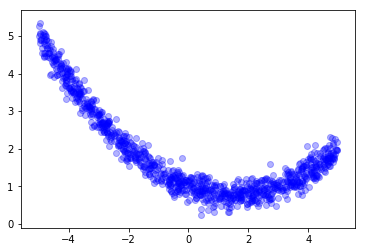

In [45]:
f,a = plt.subplots()
for x_data, y_data in data_ensemble:
    a.scatter(x_data, y_data, c='b', alpha=0.3)

## Ensemble of experiments

In [46]:
experiment_ensemble = generate_experiment_ensemble(f_truth=polynomial, theta_truth=[1.0, 2.0, -0.2],
                             model_pol_degree=2, lam=0.0,
                             y_sigma=1.0,
                             n_pts=10, n_trials=1000)

In [47]:
def sin(x, theta):
    s = theta[0]*np.sin(x*theta[1])
    return s

In [48]:
experiment_ensemble = generate_experiment_ensemble(f_truth=sin, theta_truth=[2.0, 1.0],
                             model_pol_degree=2, lam=0.0,
                             y_sigma=1.0,
                             n_pts=10, n_trials=1000)

(<matplotlib.figure.Figure at 0x7f3c5c9210f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3c5c571a58>)

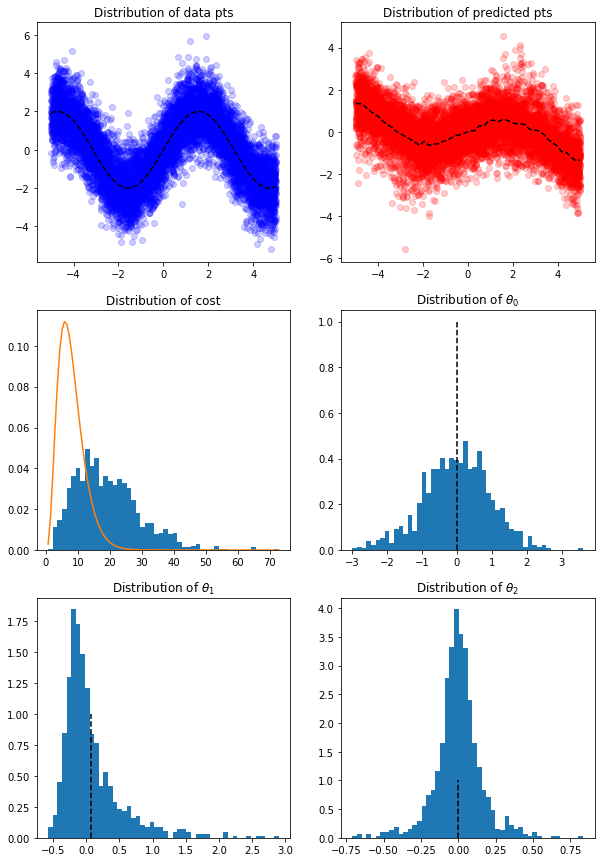

In [49]:
experiment_ensemble_dashboard(experiment_ensemble)

## Single dataset

In [50]:
dataset_index = 5

In [51]:
experiment_ensemble['theta_opt'][dataset_index]

array([-1.00164177, -0.23751878,  0.0773624 ])

In [52]:
experiment_ensemble['data'][dataset_index]

array([[-0.5790812 ,  2.82357148,  0.77151761,  3.90150537,  3.36865296,
        -1.77657025,  0.23651286,  3.6011893 , -4.42639066,  4.04099586],
       [-2.02359085,  0.14831168, -1.05815596, -0.70182781, -0.4030055 ,
        -1.83741298,  0.72619022, -1.45727564,  2.22949097, -1.7052302 ]])

(<matplotlib.figure.Figure at 0x7f3c5a2dce48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3c5a3716a0>)

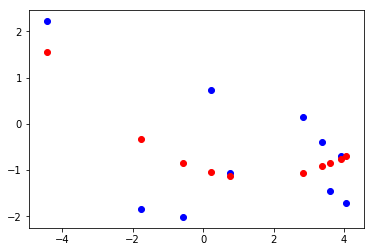

In [53]:
plot_data_and_pred_example(experiment_ensemble, dataset_index=dataset_index)